In [24]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings 
warnings.filterwarnings("ignore") 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from datetime import timedelta

In [25]:
us_confirmed_npl=pd.read_csv('./data/us_confirmed_npl.csv')
us_confirmed_npl.columns=['Date', 'Aggregated', 'Daily New']

us_death_npl=pd.read_csv('./data/us_death_npl.csv')
us_death_npl.columns=['Date', 'Aggregated', 'Daily New']
us_death_npl.head()

,Date,Aggregated,Daily New
0,1/22/2020,0,0.0
1,1/23/2020,0,0.0
2,1/24/2020,0,0.0
3,1/25/2020,0,0.0
4,1/26/2020,0,0.0


In [26]:
us_conf_dnew=us_confirmed_npl.drop('Aggregated',axis=1)
us_conf_dnew['Date'] = pd.to_datetime(us_conf_dnew['Date'], format="%m/%d/%Y")
us_conf_dnew.set_index('Date',inplace=True)

us_dea_dnew=us_death_npl.drop('Aggregated',axis=1)
us_dea_dnew['Date'] = pd.to_datetime(us_dea_dnew['Date'], format="%m/%d/%Y")
us_dea_dnew.set_index('Date',inplace=True)
us_dea_dnew.head()

,Daily New
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


The below function uses train and test the linear regression model on the data to determine the number of days the model can predict with reasonable error (MAPE<25%). The test size is chosen to be defaultly at 20% of the whole data size.

In [27]:
def train_linear_reg(data, name, test_size=0.20, predict_day=7, plot=True):
    split_day=int(math.floor((1-test_size)*(data.shape[0]-predict_day)))       # the first day of test
    x_train=data[:split_day][['Daily New']]
    y_train=data[predict_day:split_day+predict_day][['Daily New']]
    x_test=data[split_day:-predict_day][['Daily New']]
    y_test=data[split_day+predict_day:][['Daily New']]

    #linear regression fit
    l_reg = LinearRegression()
    l_reg.fit(x_train, y_train)
    predictions=l_reg.predict(x_test)
    
    #record error
    mape = np.mean(abs((y_test-predictions)/y_test))*100
    smape = np.mean((np.abs(predictions - y_test) * 200/ (np.abs(predictions) + np.abs(y_test))).fillna(0))
    error=pd.DataFrame({'Predicted days': predict_day, 'test group percent':test_size,'MAPE':mape, 'SMAPE': smape})
    if plot:
        print(error)                 #show errors with plot
    
    if plot:
        #plot Actual vs. Predicted for test group
        plt.figure(figsize=(12,6))
        plt.plot(y_train.append(y_test), label="Actual Data")
        plt.plot(y_test.index, predictions, color='r', label="Predicted Data, MAPE={}".format(round(mape[0],2)))
        plt.title('Actual vs. Predicted {} Case Counts with {}-day forecast for the Test Group'.format(name, predict_day), fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Case Counts', fontsize=16)
        plt.xticks(rotation = 45)
        plt.legend(fontsize=13)
        plt.show()
    
    return error

In [28]:
conf_errors=pd.DataFrame()
dea_errors=pd.DataFrame()

In [43]:
def find_predict_day(data, name, start=7, end=42, set_day=0, plot=False):
    error_df=pd.DataFrame()
    for i in range(start,end+1,7):     #iterate between start and end 7 days at a time
        error_df=error_df.append(train_linear_reg(data, name, predict_day=i, plot=False))
    
    good_predict_day=error_df.loc[error_df['MAPE']<25].iloc[-1,0]     #last day that satisfies MAPE<25%
    if set_day != 0:
        good_predict_day=set_day   # if specific days of forecast is requested
    if plot:
        # plot good_predict_day's prediction
        _=train_linear_reg(data, name, predict_day=good_predict_day, plot=True)
        
        #plot MAPE vs predict_day
        plt.figure(figsize=(12,6))
        plt.plot(error_df['Predicted days'], error_df['MAPE'], marker='o', label="MAPE")
        plt.plot(error_df['Predicted days'], [25]*error_df.shape[0], color='r', label="threshold")
        plt.title('Moving Absolute Percentage Error (MAPE) vs. Predict Days for {} case counts'.format(name), fontsize=16)
        plt.xlabel('Number of Predicted Days', fontsize=16)
        plt.ylabel('MAPE', fontsize=16)
        plt.legend(fontsize=13)
        plt.show()
    return (error_df, good_predict_day)

           Predicted days  test group percent       MAPE      SMAPE
Daily New               7                 0.2  19.883265  17.422962


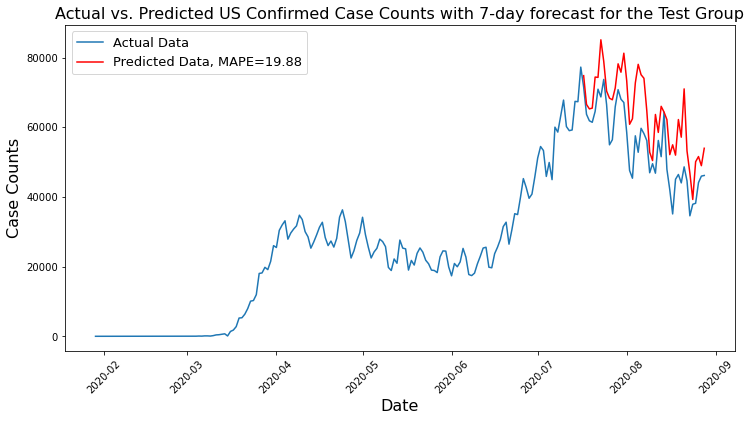

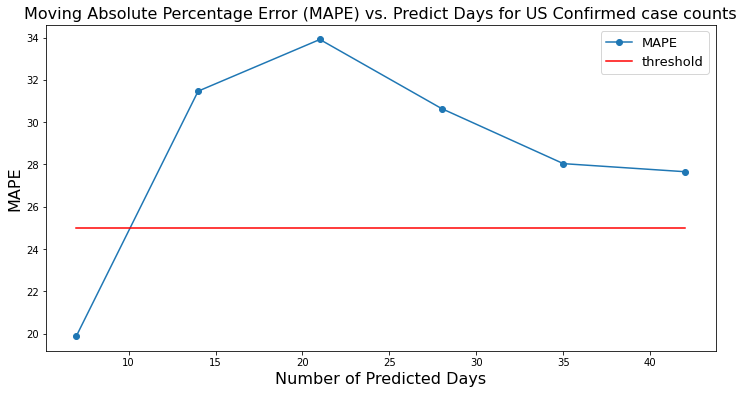

In [42]:
(conf_errors, good_predict_day)=find_predict_day(us_conf_dnew, 'US Confirmed', plot=True)

           Predicted days  test group percent       MAPE     SMAPE
Daily New              14                 0.2  31.465794  26.40093


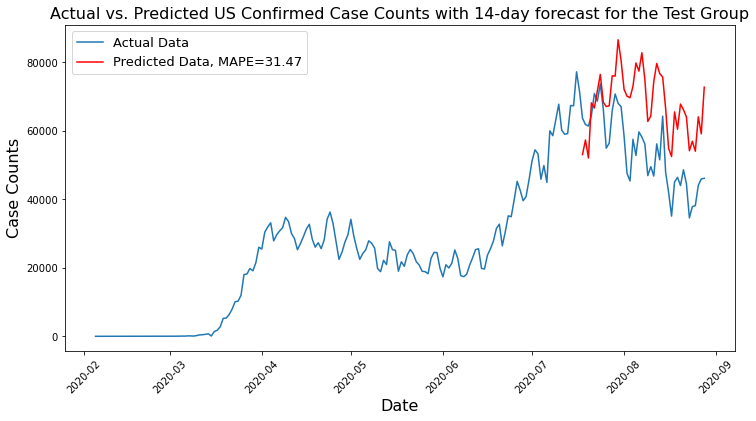

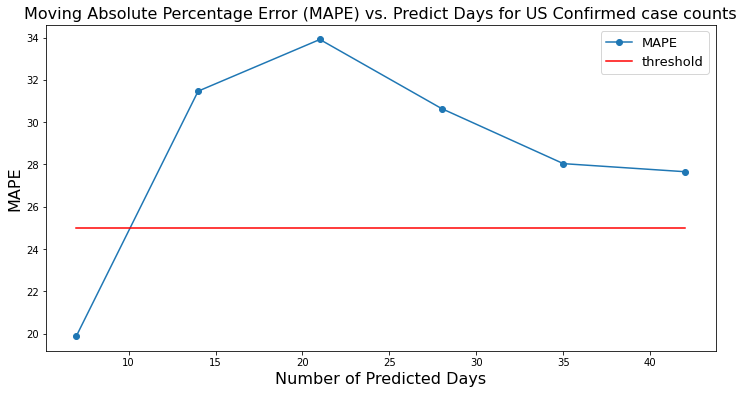

In [44]:
(conf_errors, good_predict_day)=find_predict_day(us_conf_dnew, 'US Confirmed', set_day=14, plot=True)

In [32]:
conf_errors

,Predicted days,test group percent,MAPE,SMAPE
Daily New,7,0.2,19.883265,17.422962
Daily New,14,0.2,31.465794,26.400930
Daily New,21,0.2,33.911202,28.440972
Daily New,28,0.2,30.642034,28.212767
Daily New,35,0.2,28.036384,28.926669
Daily New,42,0.2,27.654162,31.499206


           Predicted days  test group percent       MAPE      SMAPE
Daily New              14                 0.2  21.675178  21.083591


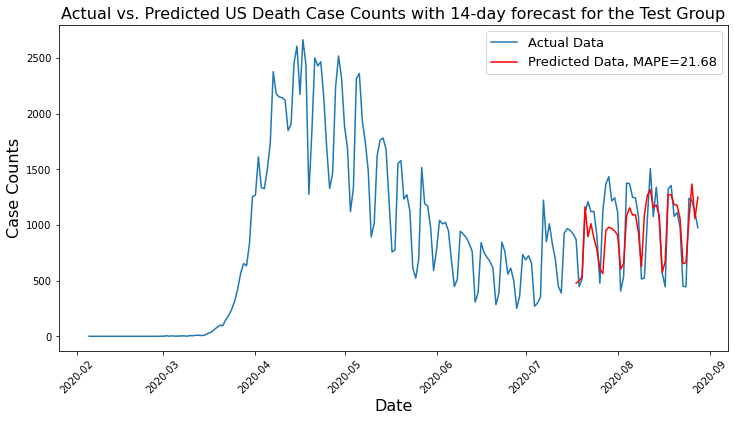

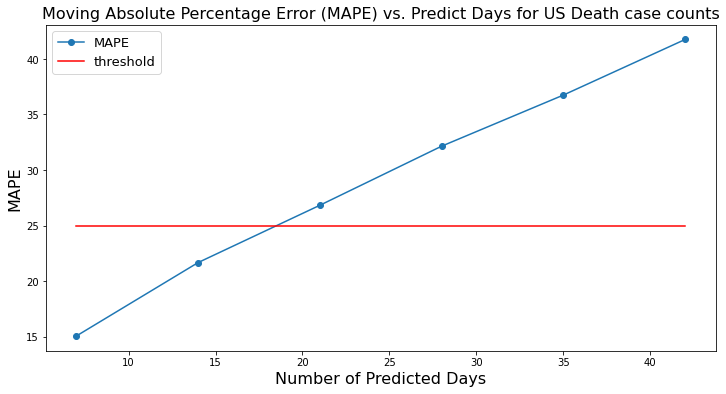

In [33]:
(dea_errors, good_predict_day)=find_predict_day(us_dea_dnew, 'US Death', plot=True)

           Predicted days  test group percent       MAPE      SMAPE
Daily New               7                 0.2  15.067178  14.363126


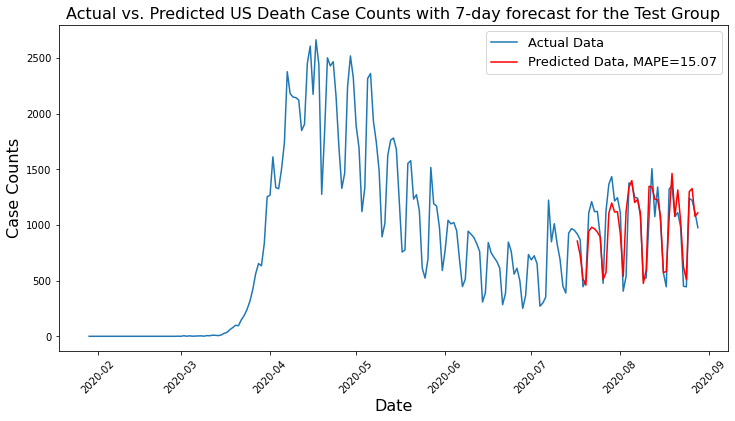

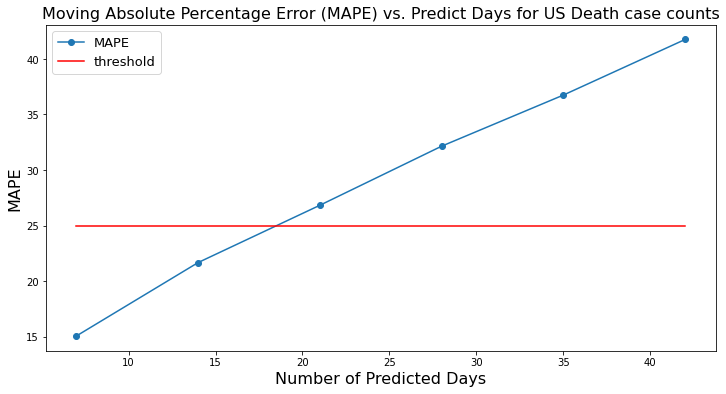

In [45]:
(dea_errors, good_predict_day)=find_predict_day(us_dea_dnew, 'US Death', set_day=7, plot=True)

In [34]:
dea_errors

,Predicted days,test group percent,MAPE,SMAPE
Daily New,7,0.2,15.067178,14.363126
Daily New,14,0.2,21.675178,21.083591
Daily New,21,0.2,26.831474,25.389263
Daily New,28,0.2,32.147510,29.422330
Daily New,35,0.2,36.748627,30.786508
Daily New,42,0.2,41.752979,30.961405


In [35]:
x=dea_errors['MAPE'].loc[dea_errors['Predicted days']==7].at['Daily New']
x

15.0671778833974

In [36]:
def forecast_linear_reg(data, name, predict_day, forecast_df, errors_df, plot=True):
    l_reg = LinearRegression()
    
    #linear regression fit
    l_reg.fit(data[:-predict_day], data[predict_day:])
    predictions=l_reg.predict(data[-predict_day:])
        
    #add predictions to data
    forecast_df[name]=predictions

    if plot:
        #plot Actual vs. Predicted for test group
        plt.figure(figsize=(12,6))
        plt.plot(data, color='b', label="Actual Data")
        # connect true data to forecasted data
        temp=data[['Daily New']][-1:]
        temp.columns=[name]
        
        test_mape=errors_df['MAPE'].loc[errors_df['Predicted days']==predict_day].at['Daily New'] #label with test group MAPE
        plt.plot(temp.append(forecast_df[[name]]),label="Forecast with test group MAPE of {}%".format(round(test_mape,2)))
        
        plt.title('{} Days Forecast of {} Case Counts'.format(predict_day, name), fontsize=16)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Case Counts', fontsize=16)
        plt.xticks(rotation = 45)
        plt.legend(fontsize=13)
        plt.show()
        

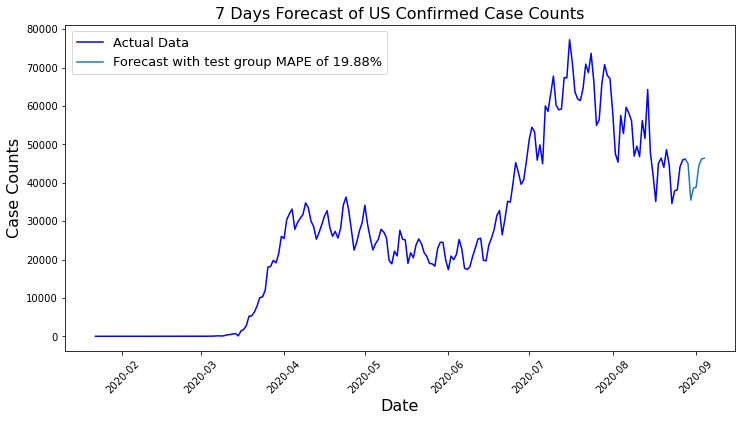

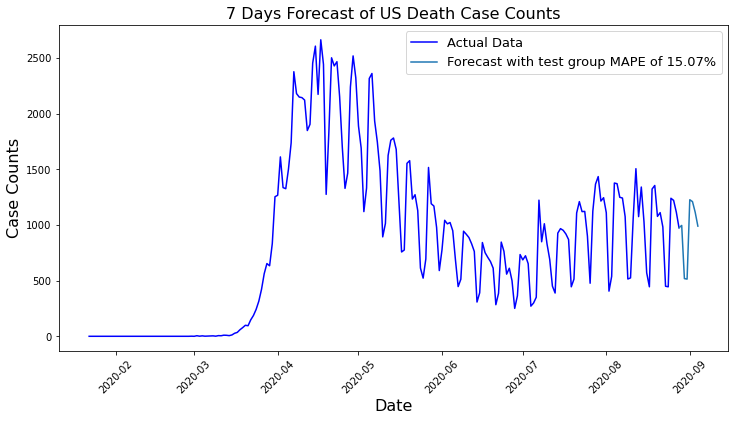

In [37]:
predict_day=7
us_7_forecast=pd.DataFrame(index=pd.to_datetime(us_conf_dnew[-predict_day:].index,format='%Y-%m-%d') + pd.to_timedelta(predict_day,unit='d'))
forecast_linear_reg(us_conf_dnew,"US Confirmed",predict_day,us_7_forecast, conf_errors,plot=True)
forecast_linear_reg(us_dea_dnew,"US Death",predict_day,us_7_forecast, dea_errors, plot=True)

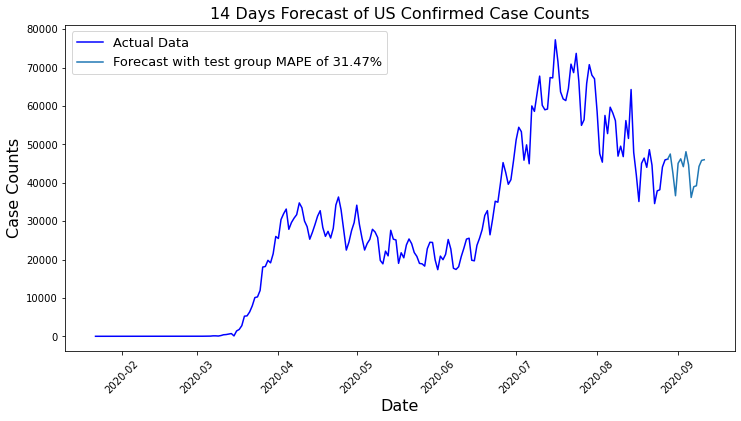

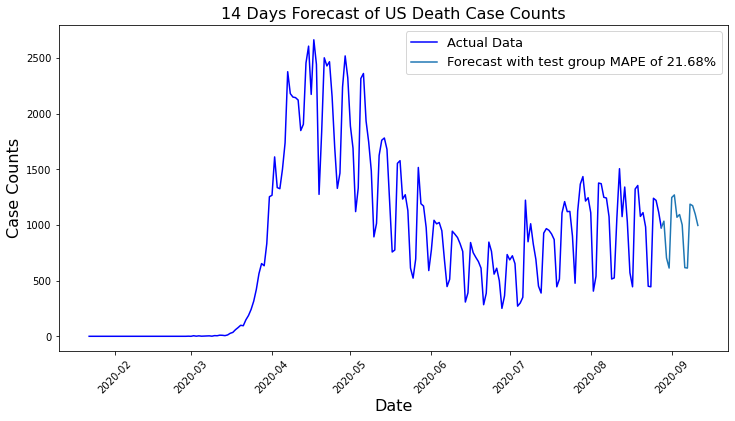

In [38]:
predict_day=14
us_14_forecast=pd.DataFrame(index=pd.to_datetime(us_conf_dnew[-predict_day:].index,format='%Y-%m-%d') + pd.to_timedelta(predict_day,unit='d'))
forecast_linear_reg(us_conf_dnew,"US Confirmed",predict_day,us_14_forecast,conf_errors,plot=True)
forecast_linear_reg(us_dea_dnew,"US Death",predict_day,us_14_forecast, dea_errors, plot=True)

In [48]:
us_7_forecast.to_csv('./forecast/us_7_forecast.csv')
us_14_forecast.to_csv('./forecast/us_14_forecast.csv')